In [205]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kstest

In [237]:
# Dictionary to store reduced model solutions in
X_CMC_dict = {}
X_full_dict = {}

Parameters

In [289]:
eps = 2**-1
K = 18  
J = 20
F = 10
hx = -1
hy = 1
dt = 10**-3
T_end = 10**3

### Integrate full L96 model

Uniform random initialization of X and Y

In [290]:
np.random.seed(0)
X_0 = 1-2*np.random.rand(K)
Y_0 = 1-2*np.random.rand(K,J)

RHS of X equation

In [291]:
def f(X,Y):
    B = hx*np.mean(Y, axis=1)
    dX = np.roll(X, 1)*(np.roll(X, -1) - np.roll(X, 2)) - X + F*np.ones(K) + B
    return dX

RHS of Y equation

In [292]:
def g(X,Y):
    dY = np.roll(Y,-1)*(np.roll(Y, 1) - np.roll(Y, -2)) - Y + hy*np.tile(X.reshape((K,1)), (1,J))
    dY *= 1/eps
    return dY

Integrate with RK-2 method

In [293]:
def RK_2(X_0, Y_0, N):
    X = np.zeros((K, N))
    Y = np.zeros((K, J, N))
    
    X[:,0] = X_0
    Y[:,:,0] = Y_0

    for n in range(1,N):
        # # Runge-Kutta 2 integration
        k1_X = dt * f(X[:,n-1], Y[:,:,n-1])
        k1_Y = dt * g(X[:,n-1], Y[:,:,n-1])
        
        k2_X = dt * f(X[:,n-1] + k1_X, Y[:,:,n-1] + k1_Y)
        k2_Y = dt * g(X[:,n-1] + k1_X, Y[:,:,n-1] + k1_Y)
        
        X[:,n] = X[:,n-1] + 0.5 * (k1_X + k2_X)
        Y[:,:,n] = Y[:,:,n-1] + 0.5 * (k1_Y + k2_Y)
    
    return X, Y


In [294]:
t_array = np.arange(0, T_end+dt, dt)
X_full, Y_full = RK_2(X_0, Y_0, len(t_array))
X_full_dict[eps] = X_full

Save the outcomes with time resolution $Dt$ separately

### Create reduced model

In [296]:
Dt = 10**-2
stepsize = int(Dt/dt)
X_full_coarse = X_full[:,::stepsize]
Y_full_coarse = Y_full[:,:,::stepsize]
B_full_coarse = hx*np.mean(Y_full_coarse, axis=1)
X_full_coarse_flattened = X_full_coarse.flatten()
B_full_coarse_flattened = B_full_coarse.flatten()

Create bins $I_{i}$ for $X_{k}$ 

In [412]:
N_bins_X = 4
X_bin_edges = np.linspace(-4.5, 9.5, N_bins_X -1)
X_bin_edges

array([-4.5,  2.5,  9.5])

Create bins $\mathcal{J}^{i}_{n}$ for $B_k$

In [413]:
N_bins_B = 8
B_bins_edges = np.zeros((N_bins_X, N_bins_B-1))

X_coarse_flattened_bins = np.digitize(X_full_coarse_flattened, X_bin_edges)

for n in range(N_bins_X):
    X_bin_index = np.where(X_coarse_flattened_bins == n)
    B_coarse_flattened_bin = B_full_coarse_flattened[X_bin_index]
    bins = np.quantile(B_coarse_flattened_bin, np.linspace(0, 1, N_bins_B + 1))
    B_bins_edges[n,:] = bins[1:-1]

B_bins_edges

array([[-0.87762489, -0.41130616, -0.06816293,  0.22065425,  0.49615678,
         0.78582422,  1.14686382],
       [-1.6379734 , -0.99098438, -0.5794145 , -0.26055301,  0.02710964,
         0.32806527,  0.69360721],
       [-3.03083783, -2.53573324, -2.17690233, -1.86342933, -1.55737989,
        -1.22139012, -0.80415729],
       [-4.14360029, -3.75611815, -3.46303426, -3.18919579, -2.9244708 ,
        -2.63906575, -2.2829402 ]])

Calculate transition matrices

In [414]:
T = np.zeros((N_bins_X, N_bins_B, N_bins_X, N_bins_B))
for n in range(len(X_full_coarse_flattened)-1):
    X_n = X_full_coarse_flattened[n]
    B_n = B_full_coarse_flattened[n]
    X_n_bin = X_coarse_flattened_bins[n]
    B_n_bin = np.digitize(B_n, B_bins_edges[X_n_bin,:])
    B_n_next = B_full_coarse_flattened[n+1]
    X_n_next_bin = X_coarse_flattened_bins[n+1]
    B_n_next_bin = np.digitize(B_n_next, B_bins_edges[X_n_next_bin,:])
    T[X_n_bin, B_n_bin, X_n_next_bin, B_n_next_bin] += 1

In [415]:
P = np.zeros((N_bins_X, N_bins_B, N_bins_X, N_bins_B))
for i in range(N_bins_X):
    for n in range(N_bins_B):
        for j in range(N_bins_X):
            if np.sum(T[i,n,j,:]) != 0:
                for m in range(N_bins_B):
                    P[i,n,j,m] = T[i,n,j,m]/np.sum(T[i,n,j,:])
            else:
                P[i,n,j,n] = 1

Calculate $B$ averages in every bin $\mathcal{J}_{n}^{i}$

In [416]:
B_means = np.zeros((N_bins_X, N_bins_B))

for n in range(N_bins_X):
    B_n_bins_edges = B_bins_edges[n,:]
    X_bin_index = np.where(X_coarse_flattened_bins == n)
    B_coarse_flattened_bin = B_full_coarse_flattened[X_bin_index]
    B_k_bin_index = np.digitize(B_coarse_flattened_bin, B_n_bins_edges)
    for j in range(N_bins_B):
        B_k_bin_index_j = np.where(B_k_bin_index == j)
        B_means[n,j] = np.mean(B_coarse_flattened_bin[B_k_bin_index_j])

Scatter plots of $B_{k}$ versus $X_{k}$ for all $k\in[K]$, also showing the bins

Text(0, 0.5, '$B_{k}$')

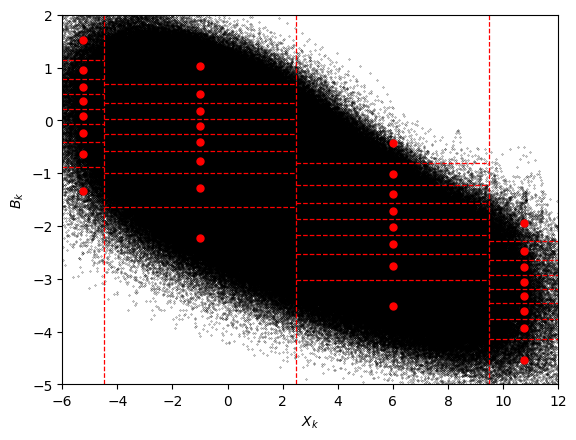

In [417]:
plt.scatter(X_full_coarse_flattened, B_full_coarse_flattened, s=0.05, c='black')


#Plot first  X bin and corresponding B bins
plt.axvline(X_bin_edges[0], linestyle="dashed", lw=0.9, color="red")
B_0_bins_edges = B_bins_edges[0,:]
X_bin_0_midpoint = (X_bin_edges[0]+ -6)/2
for m in range(N_bins_B-1):
    plt.hlines(y=B_0_bins_edges[m],
            xmin=-6,
            xmax=X_bin_edges[0],
            linestyle="dashed", 
            lw=0.9,
            colors="red"
    )
    plt.scatter(X_bin_0_midpoint, B_means[0,m], c='red', marker="o", s=25)
plt.scatter(X_bin_0_midpoint, B_means[0,m+1], c='red', marker="o", s=25)

#Plot the remaining bins
for n in range(1,N_bins_X-1):
    plt.axvline(X_bin_edges[n], linestyle="dashed", lw=0.9, color="red")
    B_n_bins_edges = B_bins_edges[n,:]
    X_bin_midpoint = (X_bin_edges[n]+ X_bin_edges[n-1])/2
    for m in range(N_bins_B-1):
        plt.hlines(y=B_n_bins_edges[m],
                   xmin=X_bin_edges[n-1],
                   xmax=X_bin_edges[n],
                   linestyle="dashed", 
                   lw=0.9,
                   colors="red"
        )
        
        plt.scatter(X_bin_midpoint, B_means[n,m], c='red', marker="o", s=25)
    plt.scatter(X_bin_midpoint, B_means[n,m+1], c='red', marker="o", s=25)
 
#Plot last X bin and corresponding B bins
B_last_bins_edges = B_bins_edges[-1,:]
X_bin_last_midpoint = (X_bin_edges[-1]+ 12)/2
for m in range(N_bins_B-1):
    plt.hlines(y=B_last_bins_edges[m],
            xmin=X_bin_edges[-1],
            xmax=12,
            linestyle="dashed", 
            lw=0.9,
            color="red",
    )
    plt.scatter(X_bin_last_midpoint, B_means[-1,m], c='red', marker="o", s=25)
plt.scatter(X_bin_last_midpoint, B_means[-1,m+1], c='red', marker="o", s=25)


plt.xlim((-6,12))
plt.ylim((-5,2))
plt.xlabel('$X_{k}$')
plt.ylabel('$B_{k}$')


Integrate reduced model

In [418]:
def G(X,B):
    dX = np.roll(X, 1)*(np.roll(X, -1) - np.roll(X, 2)) - X + F*np.ones(K) + B
    return dX

In [419]:
def CMC(X_0, B_0, N):
    X = np.zeros((K, N))
    B = np.zeros((K, N))
    
    X[:,0] = X_0
    B[:,0] = B_0

    for n in range(1,N):
        X_bin_current = np.digitize(X[:,n-1], X_bin_edges)
        B_bin_current = [np.digitize(B[k,n-1], B_bins_edges[X_bin_current,:][k,:]) for k in range(K)]

        # Runge-Kutta 2 integration
        k1 = Dt * G(X[:,n-1], B[:,n-1])
        k2 = Dt * G(X[:,n-1] + k1, B[:,n-1])
        X[:,n] = X[:,n-1] + 0.5*(k1+k2)

        X_bin_next = np.digitize(X[:,n], X_bin_edges)
        B_bin_next = [np.random.choice(N_bins_B, p=P[X_bin_current, B_bin_current, X_bin_next, :][k,:]) for k in range(K)]
        B[:,n] = B_means[X_bin_next, B_bin_next]
    return X

In [420]:
t_array_CMC = np.arange(0, T_end+Dt, Dt)
B_0 = hx*np.mean(Y_0, axis=1)
X_CMC_dict[(Dt,N_bins_X,N_bins_B)] = CMC(X_0, B_0, len(t_array_CMC))
# X_CMC_dict[eps] = CMC(X_0, B_0, len(t_array_CMC))

Plotting of pdf's

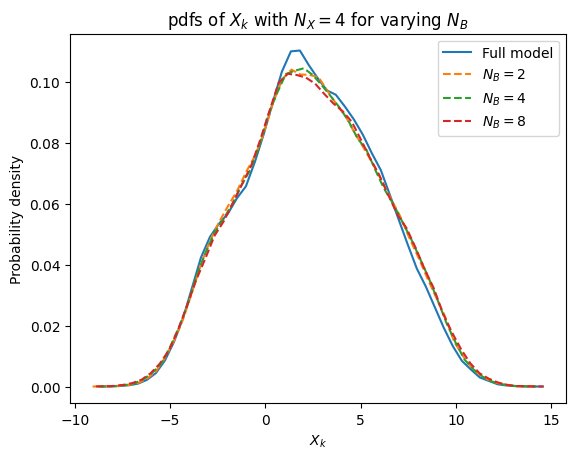

In [421]:
# Calculate the pdf
hist_full, bins_full = np.histogram(X_full.flatten(), bins=50, density=True)
bin_centers_full = (bins_full[:-1] + bins_full[1:]) / 2
pdf_full = hist_full 
plt.plot(bin_centers_full, pdf_full, label='Full model')

#Plot the pdf's
for N_bins_B in [2, 4, 8]:
    hist_CMC, bins_CMC = np.histogram(X_CMC_dict[(Dt,N_bins_X,N_bins_B)].flatten(), bins=50, density=True)
    bin_centers_CMC = (bins_CMC[:-1] + bins_CMC[1:]) / 2
    pdf_CMC = hist_CMC 
    plt.plot(bin_centers_CMC, pdf_CMC, label=rf'$N_B = {N_bins_B}$', linestyle='dashed')

plt.xlabel('$X_{k}$')
plt.ylabel('Probability density')
plt.legend()
plt.title(rf'pdfs of $X_k$ with $N_X={N_bins_X}$ for varying $N_B$')
plt.savefig(f"pdfs_varying_bins_{N_bins_X}.jpg", format="jpg", dpi=500)
plt.show()

Compute KS statistics

In [422]:
for N_bins_B in [2, 4, 8]:
    ks_stat, p_value = kstest(rvs=X_full.flatten(), cdf=X_CMC_dict[(Dt, N_bins_X, N_bins_B)].flatten())
    # Print the results
    print(f"N_X:",N_bins_X)
    print(f"N_B:",N_bins_B)
    print("KS statistic:", ks_stat)
    print("p-value:", p_value)

N_X: 4
N_B: 2
KS statistic: 0.014544038562096961
p-value: 4.3848188156038265e-301
N_X: 4
N_B: 4
KS statistic: 0.015465687936166872
p-value: 0.0
N_X: 4
N_B: 8
KS statistic: 0.018112862079447067
p-value: 0.0


In [ ]:
for epsilon in [0.5, 2**-2, 2**-4, 2**-5]:   
    ks_stat, p_value = kstest(rvs=X_full_dict[eps].flatten(), cdf=X_CMC_dict[eps].flatten())
    # Print the results
    print(f"epsilon:", eps)
    print("KS statistic:", ks_stat)
    print("p-value:", p_value)